# CNN for COVID detection from CT lung scans

### Lívia Potočňáková, TUKE, FEI, HI 

In [94]:
# import libraries and functions
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix


## 1. Data preparation

In [3]:
# set constants
SEED = 42
IMAGE_SIZE = 64

In [4]:
# define variables
disease_types=['COVID', 'non-COVID']

# set the path to the directory containing both classes
source_dir = r'D:\\Bakalarka\original_dataset'
data_dir = os.path.join(source_dir)

In [5]:
# create an array containing all data and binary class
# 0 is assigned with class COVID
# 1 is assigned with class non-COVID
all_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(data_dir, sp)):
        all_data.append(['{}/{}'.format(sp, file), defects_id])      
        
# transform the array to a dataframe
data = pd.DataFrame(all_data, columns=['File', 'DiseaseID'])
data.head()

,File,DiseaseID
0,COVID/Covid (1).png,0
1,COVID/Covid (10).png,0
2,COVID/Covid (100).png,0
3,COVID/Covid (1000).png,0
4,COVID/Covid (1001).png,0


In [6]:
# rearrange the data randomly using set seed
data = data.sample(frac=1, random_state=SEED) 
data.index = np.arange(len(data)) # Reset indices
data.head()

,File,DiseaseID
0,COVID/Covid (1227).png,0
1,COVID/Covid (430).png,0
2,non-COVID/Non-Covid (322).png,1
3,non-COVID/Non-Covid (379).png,1
4,COVID/Covid (609).png,0


<BarContainer object of 2 artists>

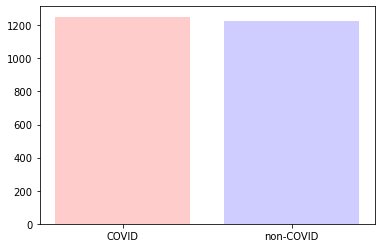

In [7]:
# set colors for charts
colors = ['#ffcccc','#cfccff','#fdffcc']

# display histogram of class distribution
counted = data.groupby('DiseaseID').count()
counted
values = list(counted['File'])
plt.bar(['COVID', 'non-COVID'], values, color = colors)

In [8]:
# function for reading images and changing them to black&white
def read_image(filepath):
    image = cv2.imread(os.path.join(data_dir, filepath))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

# function for resizing the images, containing whole image without cropping
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [9]:
# split data into file names and labels and convert them into arrays

files = data.loc[:, 'File']
labels = data.loc[:,'DiseaseID']

data_files = files.values
data_labels = labels.values

In [10]:
# split the train and test sets 
# this needs to be done before formatting in order to find out which images were badly classified later
train_data_full, test_file_data, train_labels_full, test_labels = train_test_split(data_files, data_labels, test_size=0.2, random_state=SEED)

#### <font color="darkblue">Train data formating</font>

In [11]:
# create new dataframe filled with zeros
train_formated = np.zeros((train_data_full.shape[0], IMAGE_SIZE, IMAGE_SIZE))

# resize images and save the to new dataframe
for i, file in tqdm(enumerate(train_data_full)):
    image = read_image(file)
    if image is not None:
       train_formated[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))

# normalize the data and change their shape
train_formated = train_formated / 255.
train_formated = train_formated.reshape((train_formated.shape[0], train_formated.shape[1], train_formated.shape[2], 1))
print('Data Shape: {}'.format(train_formated.shape))

1984it [00:24, 82.01it/s]

Data Shape: (1984, 64, 64, 1)


####  <font color="darkblue">Test data formating</font>

In [12]:
# create new dataframe filled with zeros
test_data = np.zeros((test_file_data.shape[0], IMAGE_SIZE, IMAGE_SIZE))

for i, file in tqdm(enumerate(test_file_data)):
    image = read_image(file)
    if image is not None:
       test_data[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))

# Normalizacia dat
test_data = test_data / 255.
test_data = test_data.reshape((test_data.shape[0], test_data.shape[1], test_data.shape[2], 1))
print('Data Shape: {}'.format(test_data.shape))

497it [00:05, 86.10it/s]

Data Shape: (497, 64, 64, 1)


In [13]:
# Split the train and validation sets 
train_data, val_data, train_labels, val_labels = train_test_split(train_formated, train_labels_full, test_size=0.1, random_state=SEED)

In [14]:
# save data labels to separate variable
formated_data_labels = data['DiseaseID'].values

#### 1.1. Visualize how the datasets were split

In [15]:
# check the shapes of arrays
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)
print(val_data.shape)
print(val_labels.shape)

(1785, 64, 64, 1)
(1785,)
(497, 64, 64, 1)
(497,)
(199, 64, 64, 1)
(199,)


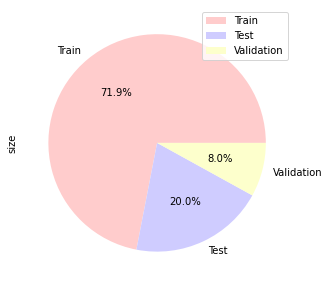

In [16]:
# display pie chart of datasets' sizes

datasets_sizes = pd.DataFrame({'size': [train_data.shape[0], test_data.shape[0], val_data.shape[0]]}, index=['Train', 'Test', 'Validation'])

datasets_sizes.plot(kind='pie', y='size', colors = colors, figsize=(5,5),  autopct='%1.1f%%')

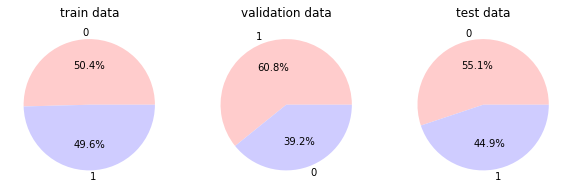

In [17]:
# display pie charts of class distribution within the datasets

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,10))

# count values in classes for each dataset
train = pd.value_counts(train_labels)
val = pd.value_counts(val_labels)
test = pd.value_counts(test_labels)

# set each plot individually
train_plot = train.plot(kind="pie", ax=axes[0],title="train data", colors= colors, labeldistance = 1.1, autopct='%1.1f%%')
val_plot = val.plot(kind="pie", ax=axes[1], title="validation data", colors= colors, labeldistance = 1.1, autopct='%1.1f%%')
test_plot = test.plot(kind="pie", ax=axes[2], title="test data", colors= colors, labeldistance = 1.1, autopct='%1.1f%%')

# hide the y axis labels since we don't need them
train_plot.yaxis.set_visible(False)
val_plot.yaxis.set_visible(False)
test_plot.yaxis.set_visible(False)

## 2. Define the model architecture

In [80]:
# build the model
model = Sequential()
model.add(Conv2D(48, 5, padding = 'same', activation = 'relu', input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
model.add(MaxPool2D(pool_size = 3, strides = 2))
model.add(Conv2D(64, 5, padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size = 3, strides = (2,2)))

model.add(Conv2D(32, 3, padding = 'same', activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(1024, activation = 'relu'))

model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))

In [81]:
# print out the model summary
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 64, 64, 48)        1248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 31, 31, 48)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 31, 31, 64)        76864     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 15, 15, 32)        18464     
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
dense_16 (Dense)             (None, 15, 15, 1024)     

## 3. Train the model

In [82]:
# compile the model
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc'])

# choose the model filename and set it as checkpoint
saved_model = "mymodel.hdf5"
# set the monitor to val_acc so the model tries to maximaze it
checkpoint = ModelCheckpoint(saved_model, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# train the model on 50 epochs while saving the best model to a file
model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs = 50, batch_size = 64, callbacks=[checkpoint])

Epoch 1/50
28/28 [==============================] - ETA: 0s - loss: 0.6962 - acc: 0.5445
Epoch 00001: val_acc improved from -inf to 0.39196, saving model to mymodel.hdf5
28/28 [==============================] - 13s 470ms/step - loss: 0.6962 - acc: 0.5445 - val_loss: 0.7591 - val_acc: 0.3920
Epoch 2/50
28/28 [==============================] - ETA: 0s - loss: 0.6473 - acc: 0.6106
Epoch 00002: val_acc improved from 0.39196 to 0.76382, saving model to mymodel.hdf5
28/28 [==============================] - 13s 476ms/step - loss: 0.6473 - acc: 0.6106 - val_loss: 0.4946 - val_acc: 0.7638
Epoch 3/50
28/28 [==============================] - ETA: 0s - loss: 0.5850 - acc: 0.6986
Epoch 00003: val_acc improved from 0.76382 to 0.78894, saving model to mymodel.hdf5
28/28 [==============================] - 15s 542ms/step - loss: 0.5850 - acc: 0.6986 - val_loss: 0.4325 - val_acc: 0.7889
Epoch 4/50
28/28 [==============================] - ETA: 0s - loss: 0.5252 - acc: 0.7507
Epoch 00004: val_acc did not 

## 4. Test the model

####  <font color="darkblue">Confusion matrix</font>

In [18]:
# load the model and save its predictions on test data
print("Loading model....")
model = load_model('mymodel.hdf5')
y_pred = model.predict(test_data)

y_int = np.zeros_like(y_pred)
print(y_int.shape)

# set model's threshold to more than 0.6
y_int[y_pred > 0.6] = 1

# save and display model's confusion matrix 
confusion_matrix_result = confusion_matrix(test_labels, y_int)
print(confusion_matrix_result)

Loading model....
(497, 1)
[[262  12]
 [  7 216]]


####  <font color="darkblue">Classification report</font>

In [98]:
# display model's classification report 
print('Classification report \n\n{}'.format(classification_report(test_labels, y_int, zero_division=0)))

Classification report 

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       274
           1       0.95      0.97      0.96       223

    accuracy                           0.96       497
   macro avg       0.96      0.96      0.96       497
weighted avg       0.96      0.96      0.96       497



#### 4.1. See which scans were incorrectly classified

####  <font color="darkblue">First, save and print their file names</font>

In [25]:
# prepare empty lists for filenames
covid_err = []
non_covid_err = []

# print out file names of incorrectly classified COVID images and save them to list
for j in range(len(y_int)):
    if  (y_int[j][0] == 1) and (test_labels[j] == 0):
        covid_err.append(test_file_data[j])
        print(test_file_data[j])

# print out file names of incorrectly classified non-COVID images and save them to list
for j in range(len(y_int)):
    if (y_int[j][0] == 0) and (test_labels[j] == 1):
        non_covid_err.append(test_file_data[j])
        print(test_file_data[j])

COVID/Covid (677).png
COVID/Covid (652).png
COVID/Covid (672).png
COVID/Covid (673).png
COVID/Covid (674).png
COVID/Covid (91).png
COVID/Covid (1226).png
COVID/Covid (1154).png
COVID/Covid (861).png
COVID/Covid (898).png
COVID/Covid (1238).png
COVID/Covid (676).png
non-COVID/Non-Covid (582).png
non-COVID/Non-Covid (191).png
non-COVID/Non-Covid (75).png
non-COVID/Non-Covid (128).png
non-COVID/Non-Covid (69).png
non-COVID/Non-Covid (70).png
non-COVID/Non-Covid (291).png


####  <font color="darkblue">Display the scans so you don't have to look them up</font>

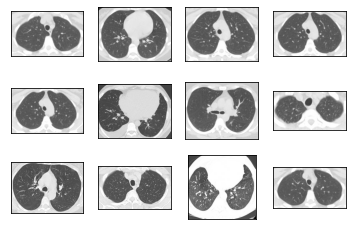

In [88]:
# display incorrect cases of covid class
ix = 1
for i in range(len(covid_err)):
    img = load_img(os.path.join(source_dir, covid_err[i]))
    ax = plt.subplot(len(covid_err)/4, len(covid_err)/3, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(img)
    ix += 1


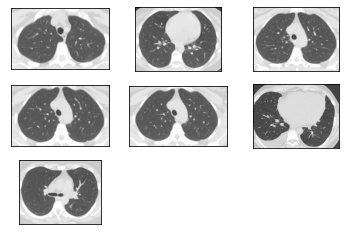

In [82]:
# display incorrect cases of non-covid class
ix = 1
for i in range(len(non_covid_err)):
    img = load_img(os.path.join(source_dir, covid_err[i]))
    ax = plt.subplot(len(non_covid_err)/2, len(non_covid_err)/2, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(img)
    ix += 1


#### 4.2. Check what the model sees 

In [90]:
#choose which image you want to check
file = data['File'][11]
file

'COVID/Covid (260).png'

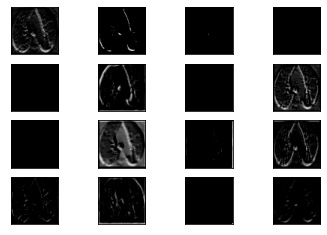

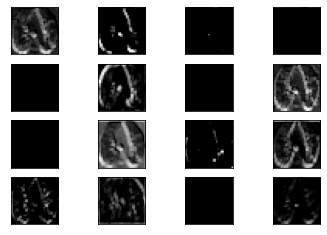

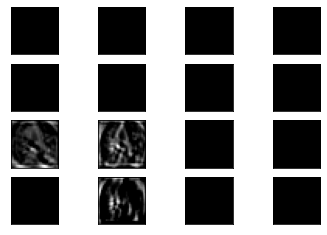

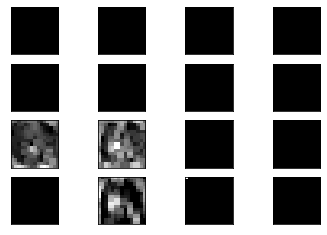

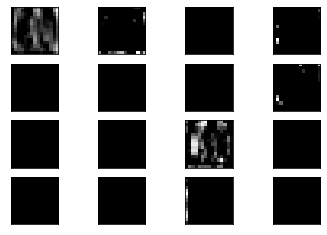

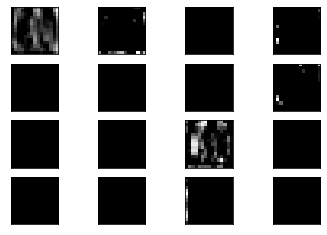

In [93]:
# redefine model to output right after the first hidden layer
ixs = [1,2,3,4,5,6] #layers
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
# load the image with the required shape
img = load_img(os.path.join(source_dir, file), target_size=(64,64))

# convert the image to an array
img = img_to_array(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# expand dimensions so that it represents a single 'sample'
img = np.expand_dims(img, axis=0)
img = np.expand_dims(img, axis=3)

# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot the output from each block - in our case each 4 rows are different layer
square = 4
for fmap in feature_maps:
	# plot all maps 
	ix = 1
	for _ in range(square):
		for _ in range(square):
			# specify subplot and turn of axis
			ax = plt.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			# plot filter channel in grayscale
			plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
			ix += 1
	# show the figure
	plt.show()
    